In [12]:
import pandas as pd
from pandas import get_dummies
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from utilities.evaluation import ModelEvaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [2]:
churn = pd.read_csv("https://raw.githubusercontent.com/stivenlopezg/DS-ONLINE-64/main/data/churn-modeling.csv", sep=',')
churn.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,Yes,Yes,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,No,Yes,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,Yes,No,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,No,No,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,Yes,Yes,79084.10,0


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        9980 non-null   object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  object 
 10  IsActiveMember   10000 non-null  object 
 11  EstimatedSalary  9988 non-null   float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 1015.8+ KB


In [4]:
churn['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [5]:
exited = churn.pop('Exited')

train_data, test_data, train_label, test_label = train_test_split(churn, exited,
                                                                  test_size=0.3,
                                                                  stratify=exited, random_state=42)

print(f'El set de entrenamiento tiene {train_data.shape[0]} observaciones, y {train_data.shape[1]} variables.')
print(f'El set de prueba tiene {test_data.shape[0]} observaciones, y {test_data.shape[1]} variables.')

El set de entrenamiento tiene 7000 observaciones, y 12 variables.
El set de prueba tiene 3000 observaciones, y 12 variables.


In [6]:
numerical_features = ['CreditScore', 'Age', 'Tenure',
                      'Balance', 'NumOfProducts', 'EstimatedSalary']

categorical_features = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember']

drop_features = ["CustomerId", "Surname"]

In [7]:
train_data = train_data.drop(labels=drop_features, axis=1)
test_data = test_data.drop(labels=drop_features, axis=1)

## Preprocesamiento

### Numericas

In [8]:
# Imputacion de datos missing

imputer_num = SimpleImputer(strategy='median')

train_data.loc[:, numerical_features] = imputer_num.fit_transform(train_data[numerical_features])

test_data.loc[:, numerical_features] = imputer_num.transform(test_data[numerical_features])

In [9]:
# Escalar datos numericos

scaler = StandardScaler()

train_data.loc[:, numerical_features] = scaler.fit_transform(train_data[numerical_features])

test_data.loc[:, numerical_features] = scaler.transform(test_data[numerical_features])

### Categoricos

In [10]:
imputer_cat = SimpleImputer(strategy='most_frequent')

train_data.loc[:, categorical_features] = imputer_cat.fit_transform(train_data[categorical_features])

test_data.loc[:, categorical_features] = imputer_cat.transform(test_data[categorical_features])

In [11]:
# OHE

train_data = get_dummies(data=train_data, columns=categorical_features)

test_data = get_dummies(data=test_data, columns=categorical_features)

## Validación cruzada

In [13]:
lr = LogisticRegression(class_weight='balanced', random_state=42)

dtree = DecisionTreeClassifier(class_weight="balanced", random_state=42)

rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

In [14]:
roc = {}
f1 = {}

roc['lr'] = cross_val_score(estimator=lr,
                            X=train_data, y=train_label, scoring="roc_auc", cv=5, n_jobs=-1)

roc['dtree'] = cross_val_score(estimator=dtree,
                               X=train_data, y=train_label, scoring="roc_auc", cv=5, n_jobs=-1)

roc['rf'] = cross_val_score(estimator=rf,
                            X=train_data, y=train_label, scoring="roc_auc", cv=5, n_jobs=-1)

# --------------------------------------------------------------------------------------------------------------------

f1['lr'] = cross_val_score(estimator=lr,
                            X=train_data, y=train_label, scoring="f1", cv=5, n_jobs=-1)

f1['dtree'] = cross_val_score(estimator=dtree,
                            X=train_data, y=train_label, scoring="f1", cv=5, n_jobs=-1)

f1['rf'] = cross_val_score(estimator=rf,
                            X=train_data, y=train_label, scoring="f1", cv=5, n_jobs=-1)

In [15]:
roc_df = pd.DataFrame.from_dict(roc)
roc_df

,lr,dtree,rf
0,0.741701,0.656848,0.828419
1,0.760334,0.689112,0.835530
2,0.778724,0.690669,0.848549
3,0.742412,0.692054,0.829014
4,0.763754,0.672280,0.851102


In [16]:
f1_df = pd.DataFrame.from_dict(f1)
f1_df

,lr,dtree,rf
0,0.466091,0.453901,0.527273
1,0.482500,0.508167,0.517647
2,0.497585,0.506066,0.547461
3,0.478764,0.509666,0.523282
4,0.482673,0.479574,0.524138


In [19]:
valor_medio = pd.concat(objs=[pd.DataFrame(roc_df.mean(), columns=["roc_auc"]),
                              pd.DataFrame(f1_df.mean(), columns=["f1_score"])], axis=1)

std = pd.concat(objs=[pd.DataFrame(roc_df.std(), columns=["roc_auc_std"]),
                      pd.DataFrame(f1_df.std(), columns=["f1_score_std"])], axis=1)

resultados = pd.concat(objs=[valor_medio, std], axis=1)
resultados

,roc_auc,f1_score,roc_auc_std,f1_score_std
lr,0.757385,0.481523,0.015611,0.011247
dtree,0.680193,0.491475,0.015310,0.024372
rf,0.838523,0.527960,0.010726,0.011441


In [20]:
lr.fit(train_data, train_label)

dtree.fit(train_data, train_label)

rf.fit(train_data, train_label)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [24]:
predictions = {}

predictions["lr"] = cross_val_predict(estimator=lr,
                                      X=test_data, y=test_label, cv=5, n_jobs=-1, method="predict_proba")[:, 1]

predictions["dtree"] = cross_val_predict(estimator=dtree,
                                      X=test_data, y=test_label, cv=5, n_jobs=-1, method="predict_proba")[:, 1]

predictions["rf"] = cross_val_predict(estimator=rf,
                                      X=test_data, y=test_label, cv=5, n_jobs=-1, method="predict_proba")[:, 1]

In [25]:
predictions = pd.DataFrame.from_dict(predictions)
predictions

,lr,dtree,rf
0,0.135019,0.0,0.01
1,0.355191,0.0,0.07
2,0.606118,0.0,0.17
3,0.402492,0.0,0.04
4,0.647136,1.0,0.49
...,...,...,...
2995,0.931596,0.0,0.13
2996,0.396265,0.0,0.38
2997,0.691426,1.0,0.40
2998,0.567390,0.0,0.50


c:\users\stiven.lopez\pycharmprojects\ds-online-64\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\stiven.lopez\pycharmprojects\ds-online-64\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\stiven.lopez\pycharmprojects\ds-online-64\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

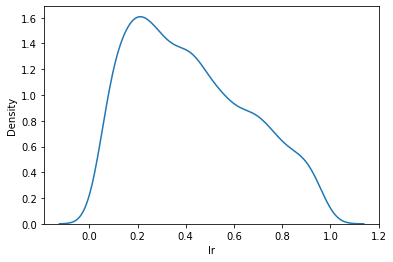

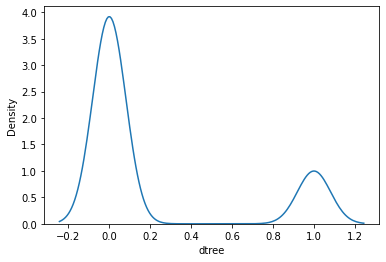

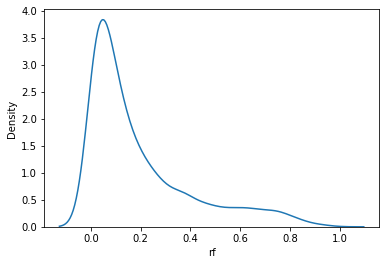

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

for model in predictions.columns:
    sns.distplot(predictions[model], hist=False)
    plt.show()

In [28]:
train_data.sample()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain,HasCrCard_No,HasCrCard_Yes,IsActiveMember_No,IsActiveMember_Yes
9408,-0.109418,1.513266,1.725435,0.89982,-0.912483,-1.714638,0,1,1,0,0,0,1,1,0


In [30]:
for column, importance in sorted(zip(train_data.columns, dtree.feature_importances_)):
    print(f"Para la variable {column}, la importancia es: {importance}")

Para la variable Age, la importancia es: 0.23582294821566965
Para la variable Balance, la importancia es: 0.15904104908692374
Para la variable CreditScore, la importancia es: 0.14410233459653915
Para la variable EstimatedSalary, la importancia es: 0.15149428668956472
Para la variable Gender_Female, la importancia es: 0.01495293351821285
Para la variable Gender_Male, la importancia es: 0.007769710671882109
Para la variable Geography_France, la importancia es: 0.007945380679646922
Para la variable Geography_Germany, la importancia es: 0.022065544281946403
Para la variable Geography_Spain, la importancia es: 0.011294372175568786
Para la variable HasCrCard_No, la importancia es: 0.010372287467657094
Para la variable HasCrCard_Yes, la importancia es: 0.0053476378213640685
Para la variable IsActiveMember_No, la importancia es: 0.007384206421939778
Para la variable IsActiveMember_Yes, la importancia es: 0.031355545759762224
Para la variable NumOfProducts, la importancia es: 0.1258144638960790